In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## Random 充電/放電結果

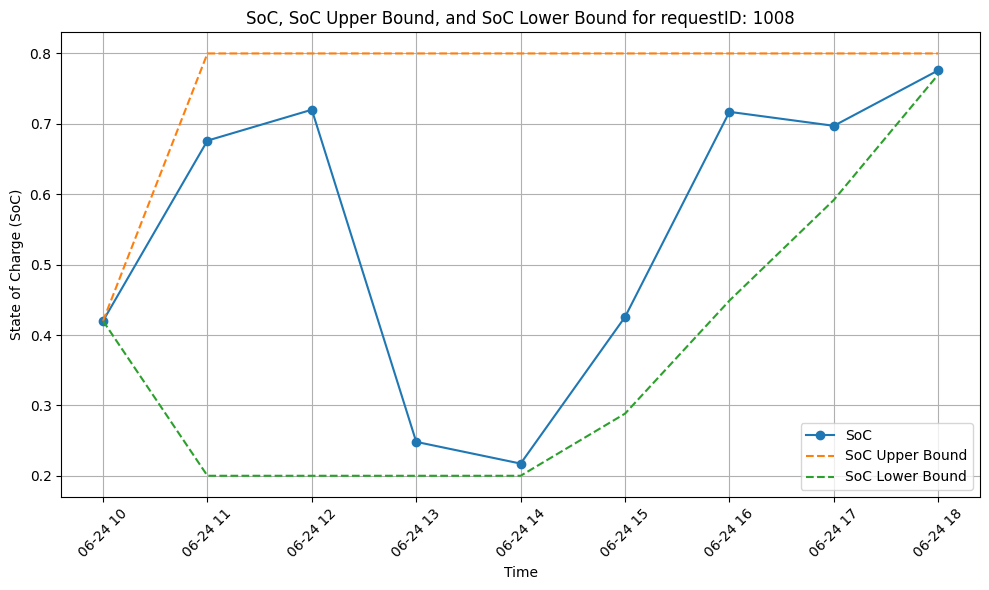

In [49]:
# Read the CSV file
file_path = './Result/Random/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage 
plot_soc_for_requestID(1008)  # Replace with the desired requestID


## MARL 充電/放電結果

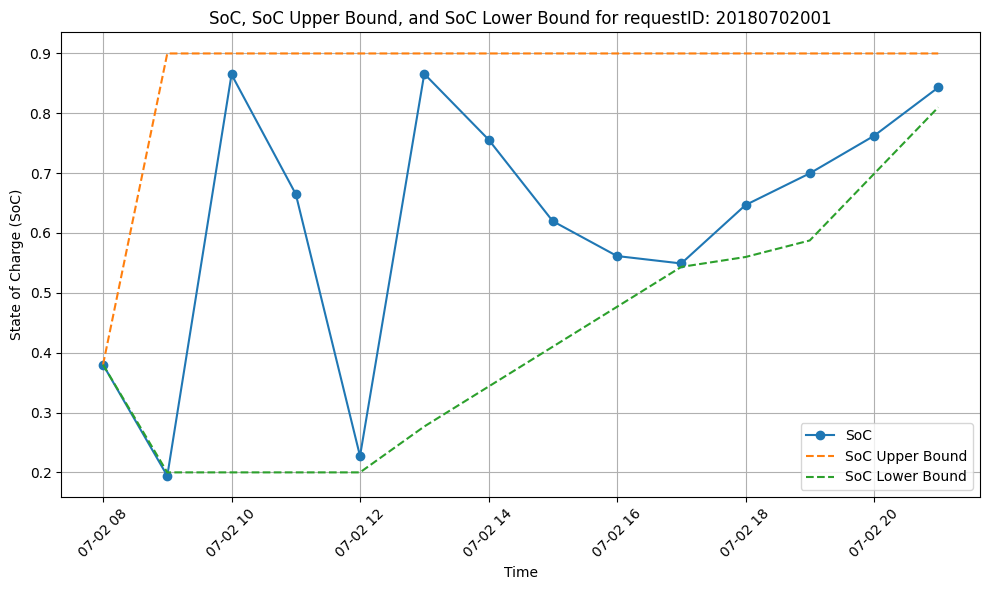

In [8]:
# Read the CSV file
file_path = './Result/EVBuildingEnv/98/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage
plot_soc_for_requestID(20180702001)  # Replace with the desired requestID


## 原始負載與 EV 充放電的負載變化圖

In [4]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

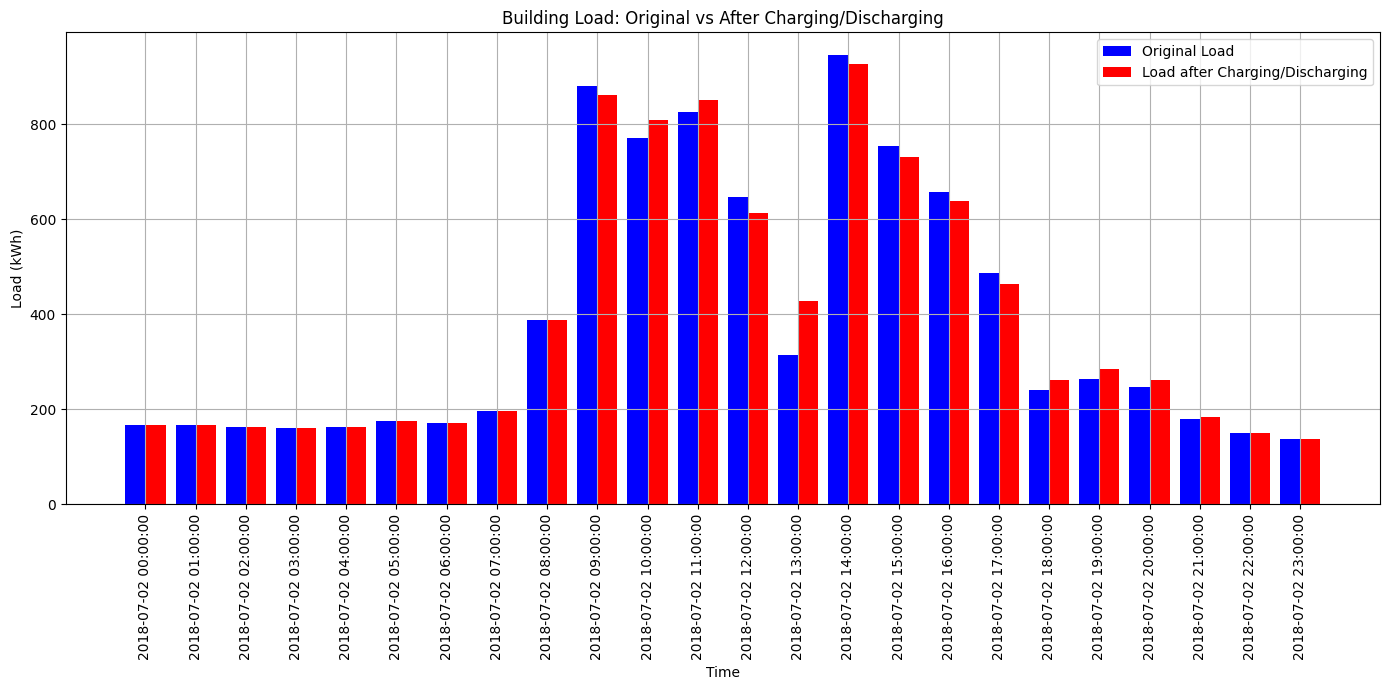

In [11]:
file_path = './Result/EVBuildingEnv/99/load_history.csv'  # Modify this to the path of your load history file
start_date = '2018-07-02'
end_date = '2018-07-03'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

plot_load_history(file_path, start_date, end_date)

## Actor Loss

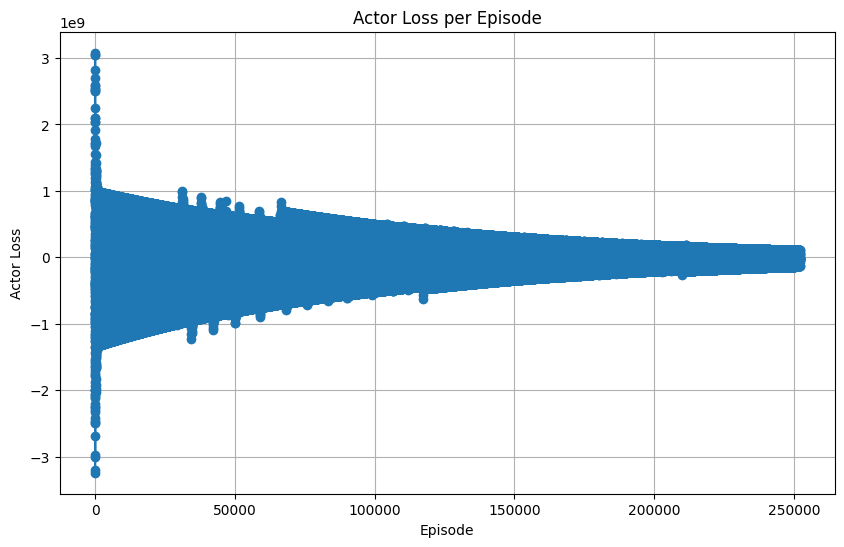

In [8]:
# read the CSV file
csv_file = "./Result/MARL/losses.csv"  
data = pd.read_csv(csv_file)

# 視覺化Loss資料
plt.figure(figsize=(10, 6))
plt.plot(data['Episode'], data['Actor Loss'], marker='o', linestyle='-')
plt.title('Actor Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Actor Loss')
plt.grid(True)
plt.show()


## Rewards

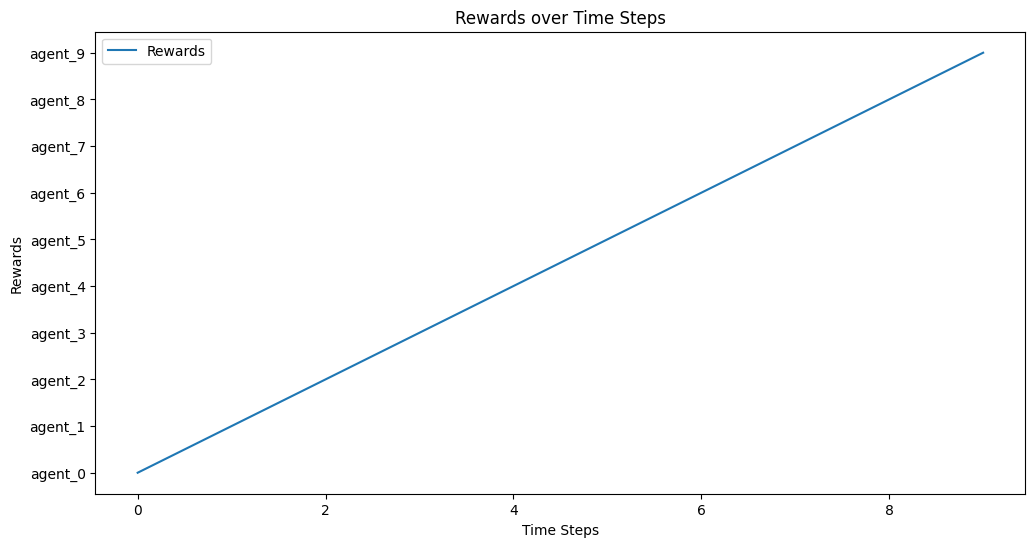

In [10]:
import pickle
import matplotlib.pyplot as plt

# 读取 Rewards.pkl 文件中的数据
with open('./Result/EVBuildingEnv/98/rewards.pkl', 'rb') as f:
    rewards = pickle.load(f)

# 假设 rewards 是一个包含多个 episode 的奖励列表
# 如果 rewards 是一个字典，其中包含每个 episode 的奖励列表，可以进一步处理数据
if isinstance(rewards, dict):
    rewards = [episode_rewards for episode_rewards in rewards.values()]

# 平展 rewards 列表（如果是嵌套列表）
flattened_rewards = [reward for episode_rewards in rewards for reward in episode_rewards]

# 创建一个时间步列表，用于 x 轴
time_steps = list(range(len(flattened_rewards)))

# 可视化数据
plt.figure(figsize=(12, 6))
plt.plot(time_steps, flattened_rewards, label='Rewards')
plt.xlabel('Time Steps')
plt.ylabel('Rewards')
plt.title('Rewards over Time Steps')
plt.legend()
plt.show()


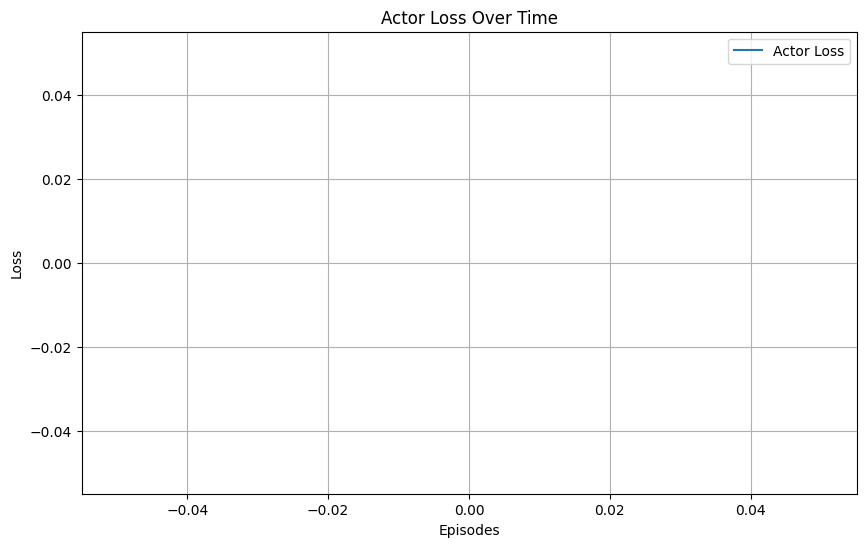

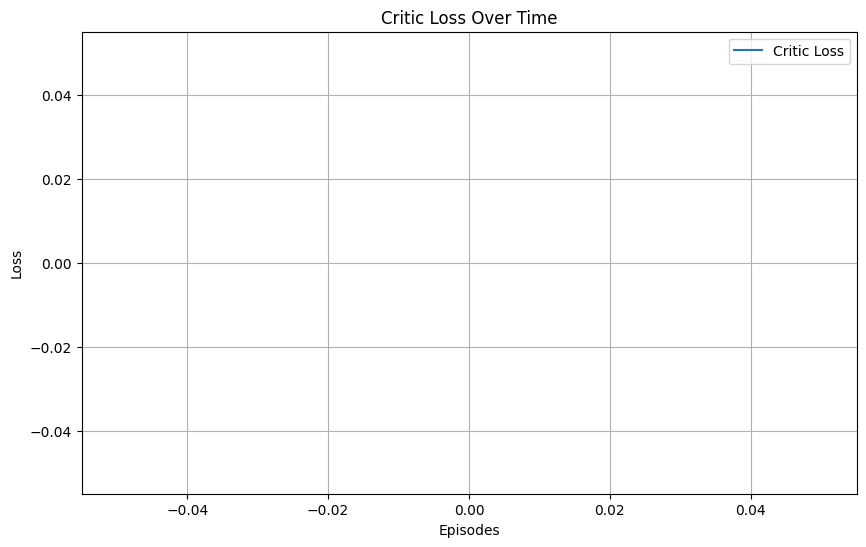

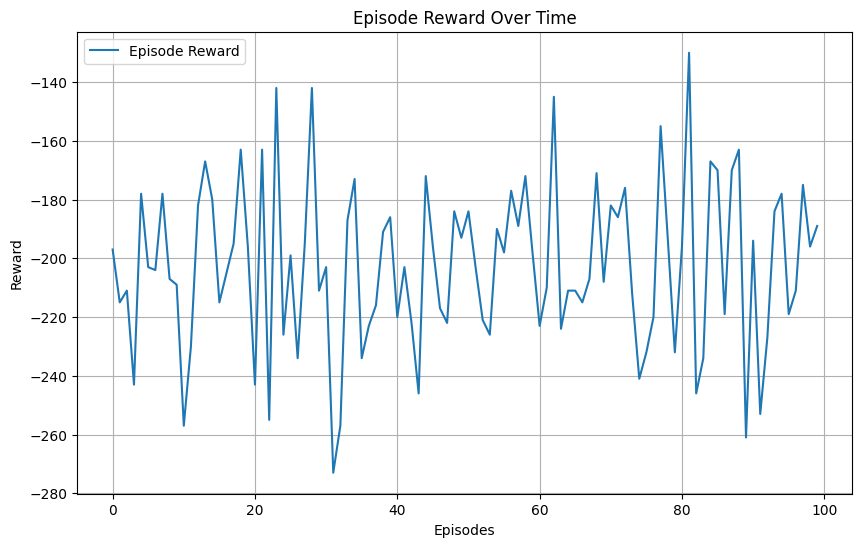

In [1]:
import pickle
import matplotlib.pyplot as plt

# 从pickle文件中加载数据
with open('./Methods/actor_losses.pkl', 'rb') as f:
    actor_losses = pickle.load(f)

with open('./Methods/critic_losses.pkl', 'rb') as f:
    critic_losses = pickle.load(f)

with open('./Methods/episode_rewards.pkl', 'rb') as f:
    episode_rewards = pickle.load(f)

# 绘制Actor损失曲线
plt.figure(figsize=(10, 6))
plt.plot(actor_losses, label='Actor Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Actor Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 绘制Critic损失曲线
plt.figure(figsize=(10, 6))
plt.plot(critic_losses, label='Critic Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Critic Loss Over Time')
plt.legend()
plt.grid()
plt.show()

# 绘制奖励曲线
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Episode Reward Over Time')
plt.legend()
plt.grid()
plt.show()
